In [1]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img,ImageDataGenerator
from tensorflow.keras.utils import to_categorical


In [3]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [4]:
import matplotlib.pyplot as plt
import numpy as np
#from qiskit.utils import QuantumInstance
from qiskit_aer import Aer
from qiskit_aer import AerSimulator


In [5]:



# Quantum computing libraries from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN



# Utilities and loss functions from PyTorch

from torch.optim import Adam
from torch.nn import BCELoss  # Binary Cross Entropy Loss for binary classification

# Optional: for advanced metrics and visualization
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility in Qiskit and PyTorch
# Set seed for random generators
from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 42
#manual_seed(42)


In [6]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import torch

In [7]:
# Define the path to the FER2013 dataset folders
data_dir = 'fer2013BinaryData'
print(os.listdir(data_dir))

['.DS_Store', 'test', 'train']


In [8]:
# Define constants
input_shape = (28, 28, 1)  # Grayscale images
num_classes = 2  # Number of emotions

# Define data directories
train_data_dir = 'fer2013BinaryData/train'
test_data_dir = 'fer2013BinaryData/test'


In [9]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Batch size
batch_size = 200 #previously 50 
# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    color_mode='grayscale',  # Grayscale images
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    classes=['notokay', 'okay']  # Specify class names
)

Found 28708 images belonging to 2 classes.


In [11]:
# Load and preprocess test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    color_mode='grayscale',  # Grayscale images
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    classes=['notokay', 'okay']  # Specify class names
)


Found 7178 images belonging to 2 classes.


In [12]:
# Get one batch of training data and labels
batch_data, batch_labels = next(train_generator)

# Display the shape of the batch data and labels
print("Batch Data Shape:", batch_data.shape)
print("Batch Labels Shape:", batch_labels.shape)
print("Batch Labels after Loading:", batch_labels)

Batch Data Shape: (50, 28, 28, 1)
Batch Labels Shape: (50,)
Batch Labels after Loading: [1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 0.]


In [13]:
print("Unique Labels in Batch:", np.unique(batch_labels))

Unique Labels in Batch: [0. 1.]


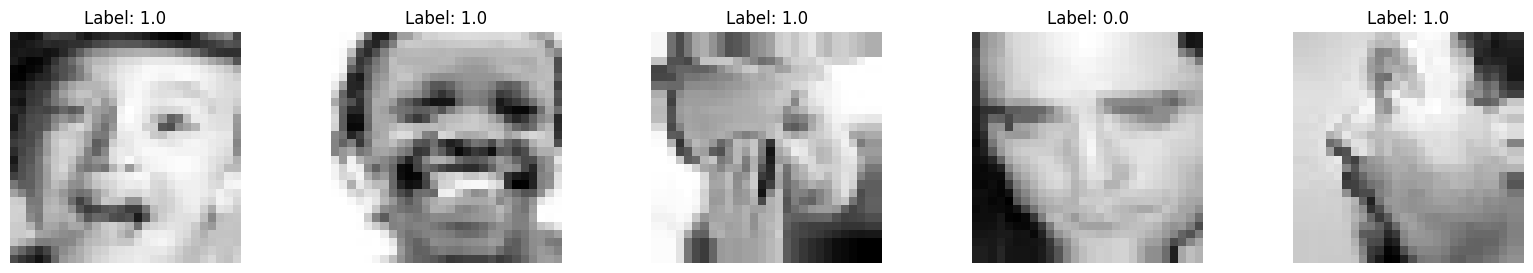

In [14]:


# Function to display images from a batch
def display_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 3))
    for i in range(num_images):
        axes[i].imshow(images[i].squeeze(), cmap='gray')  # Assuming images are grayscale
        axes[i].set_title(f"Label: {labels[i]}")  # Display the actual label directly
        axes[i].axis('off')
    plt.show()

# Display images from the batch
display_images(batch_data, batch_labels.flatten())  # Flatten the labels for display

In [15]:

# Define and create QNN
num_qubits = 2
def create_qnn():
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
    ansatz = RealAmplitudes(num_qubits, reps=1)
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn = create_qnn()


In [16]:

class HybridModel(torch.nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64) 
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply Quantum circuit HERE
        self.fc3 = Linear(1, 1) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
       # x = x.reshape(x.shape[0], -1)
        x = x.contiguous().reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #print("After fc1:", x.shape)
        x = self.fc2(x)
        #print("After fc2:", x.shape)
        x = self.qnn(x)  # apply QNN
        #print("After QNN:", x.shape)
        x = self.fc3(x)
        return torch.sigmoid(x)  # Use sigmoid to output probabilities


model = HybridModel(qnn)





In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.BCELoss()  # Binary cross-entropy loss for binary classification





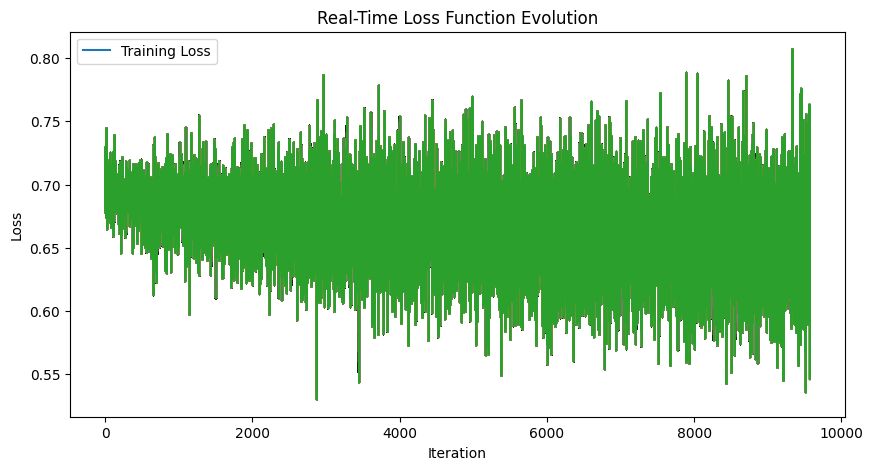

In [ ]:
# Initialize the plot
plt.figure(figsize=(10, 5))

loss_history = []  # to store loss values
time_history = []  # to store training time per epoch

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    start_time = time.time()  # Start time for the epoch

    for batch_idx, (batch_data, batch_labels) in enumerate(train_generator):
        # Convert data to tensor and send to device
        batch_data = torch.tensor(batch_data).permute(0, 3, 1, 2).float().to(device)
        batch_labels = torch.tensor(batch_labels).float().to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = loss_func(outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Real-time plot update
        loss_history.append(loss.item())
        plt.plot(loss_history, label='Training Loss' if batch_idx == 0 else "")
        plt.title('Real-Time Loss Function Evolution')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        clear_output(wait=True)
        display(plt.gcf())

    plt.clf()  # Clear the figure to prevent overlapping of old plots

    # Calculate and store epoch duration
    epoch_duration = time.time() - start_time
    time_history.append(epoch_duration)

    average_loss = total_loss / len(train_generator)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss:.4f}, Time: {epoch_duration:.2f} sec")

plt.close()  # Close the plot display

# Optionally, plot the total training time over epochs
plt.figure(figsize=(10, 5))
plt.plot(time_history, marker='o', linestyle='-')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

In [ ]:
# Initialize the plot
plt.figure(figsize=(10, 5))

loss_history = []  # to store loss values
time_history = []  # to store training time per epoch

epochs = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    start_time = time.time()  # Start time for the epoch

    for batch_idx, (batch_data, batch_labels) in enumerate(train_generator):
        # Convert data to tensor and send to device
        batch_data = torch.tensor(batch_data).permute(0, 3, 1, 2).float().to(device)
        batch_labels = torch.tensor(batch_labels).float().to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = loss_func(outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Real-time plot update
        loss_history.append(loss.item())
        plt.plot(loss_history, label='Training Loss' if batch_idx == 0 else "")
        plt.title('Real-Time Loss Function Evolution')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        clear_output(wait=True)
        display(plt.gcf())

    plt.clf()  # Clear the figure to prevent overlapping of old plots

    # Calculate and store epoch duration
    epoch_duration = time.time() - start_time
    time_history.append(epoch_duration)

    average_loss = total_loss / len(train_generator)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss:.4f}, Time: {epoch_duration:.2f} sec")

plt.close()  # Close the plot display

# Optionally, plot the total training time over epochs
plt.figure(figsize=(10, 5))
plt.plot(time_history, marker='o', linestyle='-')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()